In [1]:
import yfinance as yf
import networkx as nx
from networkx.algorithms.approximation import clique
import numpy as np
import itertools 
from itertools import combinations
import time
import pickle
import json
import ast

In [2]:
stocks = ['SBER.ME', 'YNDX.ME', 'LKOH.ME', 'ROSN.ME', 'GAZP.ME', 'RTKM.ME', 'VTBR.ME', 
          'MVID.ME', 'MTSS.ME', 'AFLT.ME', 'MGNT.ME', 'TATN.ME', 'NLMK.ME', 'MAGN.ME',
         'GMKN.ME', 'FIVE.ME', 'HYDR.ME', 'RSTI.ME', 'LNTA.ME', 'NVTK.ME', 'SNGSP.ME', 'PLZL.ME',
         'CHMF.ME', 'AFKS.ME', 'AGRO.ME', 'MSNG.ME', 'ALRS.ME', 'DSKY.ME']
data = yf.download(stocks,'2019-01-01','2020-01-01')
data = data['Adj Close']

n_days = 253

[*********************100%***********************]  28 of 28 completed


In [3]:
a_file = open("rus_all_mult_sign_dict_.json", "r")
output = a_file.read()
a_file.close()
all_mult_sign_dict = json.loads(output)

In [4]:
hipergraph_edges = {}
for num in all_mult_sign_dict.keys():
    hipergraph_edges[int(num)] = {}
    for ver in all_mult_sign_dict[num].keys():
        tuple_ver = tuple(sorted(ver.split()))
        hipergraph_edges[int(num)][tuple_ver] = all_mult_sign_dict[num][ver] / n_days

In [5]:
def get_cliques_from_hipergraph(hipergraph_edges, edge_size, threshold):    
    hipergraph_edges_threshold = {}
    for ver in hipergraph_edges:
        if hipergraph_edges[ver] >= threshold:
            hipergraph_edges_threshold[ver] = hipergraph_edges[ver]
    cliques = []
    stock_combinations = []
    for i in range(4, 9):
        stock_combinations.extend(list(combinations(stocks, i)))
    for big_comb in stock_combinations:
        if len(cliques) and len(big_comb) > len(cliques[-1]) + 1:
            break
        small_combinations = list(combinations(big_comb, edge_size))
        is_clique = True
        for small_comb in small_combinations:
            cur_three = tuple(sorted(small_comb))
            if cur_three not in hipergraph_edges_threshold:
                is_clique = False
                break
        if is_clique:
            cliques.append(big_comb)
    if len(cliques):
        max_clique_size = len(cliques[-1])
        max_cliques = []
        for cl in cliques:
            if max_clique_size == len(cl):
                max_cliques.append(cl)
        return max_cliques
    else:
        return None

In [6]:
def print_hipergraph_edges(hipergraph_edges, clique, n):
    edges = list(combinations(clique, n))
    for e in edges:
        print('Ребро клики {}: {}'.format(sorted(e), hipergraph_edges[n][tuple(sorted(e))]))
    print("\n")

In [7]:
def get_top(hipergraph_edges, n):
    sorted_dict = dict(sorted(hipergraph_edges[n].items(), key=lambda item: item[1], reverse=True)[:5])
    if len(sorted_dict):
        min_val = min(sorted_dict.values())
    
    for key, value in hipergraph_edges[n].items():
        if value == min_val and key not in sorted_dict:
            sorted_dict[key] = value
    print("Топ по совпадению знаков:")
    for elem in sorted_dict:
        print(elem, ": ", sorted_dict[elem])

In [8]:
def get_stat(size, thresold):
    print("Размер ребер {}, порог {}\n".format(size, thresold))
    max_cliques = get_cliques_from_hipergraph(hipergraph_edges[size], size, thresold)
    print(f"Количество найденных клик: {len(max_cliques)}" if len(max_cliques) else "Клики не найдены")
    if max_cliques is not None:
        max_size = len(max_cliques[0])
        print("Размер максимальной клики = ", max_size)
        for cl in max_cliques:
            ordered_cl = sorted(list(cl))
            print("Найденная клика в гиперграфе :{}".format(cl))
            print("Ее вероятность совпадения знаков :{}".format(hipergraph_edges[len(cl)][tuple(ordered_cl)]))
            print_hipergraph_edges(hipergraph_edges, cl, size)
        get_top(hipergraph_edges, max_size)

# Подбор порога, чтобы клики были размером на 1 акцию больше, чем ребро

In [23]:
get_stat(3, 0.47)

Размер ребер 3, порог 0.47

Количество найденных клик: 2
Размер максимальной клики =  4
Найденная клика в гиперграфе :('SBER.ME', 'GAZP.ME', 'VTBR.ME', 'TATN.ME')
Ее вероятность совпадения знаков :0.383399209486166
Ребро клики ['GAZP.ME', 'SBER.ME', 'VTBR.ME']: 0.5098814229249012
Ребро клики ['GAZP.ME', 'SBER.ME', 'TATN.ME']: 0.4980237154150198
Ребро клики ['SBER.ME', 'TATN.ME', 'VTBR.ME']: 0.4743083003952569
Ребро клики ['GAZP.ME', 'TATN.ME', 'VTBR.ME']: 0.4782608695652174


Найденная клика в гиперграфе :('SBER.ME', 'GAZP.ME', 'VTBR.ME', 'CHMF.ME')
Ее вероятность совпадения знаков :0.3794466403162055
Ребро клики ['GAZP.ME', 'SBER.ME', 'VTBR.ME']: 0.5098814229249012
Ребро клики ['CHMF.ME', 'GAZP.ME', 'SBER.ME']: 0.4743083003952569
Ребро клики ['CHMF.ME', 'SBER.ME', 'VTBR.ME']: 0.48221343873517786
Ребро клики ['CHMF.ME', 'GAZP.ME', 'VTBR.ME']: 0.4743083003952569


Топ по совпадению знаков:
('GAZP.ME', 'GMKN.ME', 'SBER.ME', 'TATN.ME') :  0.3952569169960474
('CHMF.ME', 'GAZP.ME', 'SBER.ME

In [33]:
get_stat(4, 0.36)

Размер ребер 4, порог 0.36

Количество найденных клик: 1
Размер максимальной клики =  5
Найденная клика в гиперграфе :('SBER.ME', 'GAZP.ME', 'VTBR.ME', 'TATN.ME', 'CHMF.ME')
Ее вероятность совпадения знаков :0.31225296442687744
Ребро клики ['GAZP.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME']: 0.383399209486166
Ребро клики ['CHMF.ME', 'GAZP.ME', 'SBER.ME', 'VTBR.ME']: 0.3794466403162055
Ребро клики ['CHMF.ME', 'GAZP.ME', 'SBER.ME', 'TATN.ME']: 0.391304347826087
Ребро клики ['CHMF.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME']: 0.3675889328063241
Ребро клики ['CHMF.ME', 'GAZP.ME', 'TATN.ME', 'VTBR.ME']: 0.3715415019762846


Топ по совпадению знаков:
('CHMF.ME', 'GAZP.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME') :  0.31225296442687744
('GAZP.ME', 'GMKN.ME', 'MTSS.ME', 'SBER.ME', 'TATN.ME') :  0.31225296442687744
('CHMF.ME', 'GAZP.ME', 'NVTK.ME', 'SBER.ME', 'TATN.ME') :  0.308300395256917
('GAZP.ME', 'GMKN.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME') :  0.30434782608695654
('CHMF.ME', 'GAZP.ME', 'MTSS.ME', 'SBER.ME', 'T

In [40]:
get_stat(5, 0.28)

Размер ребер 5, порог 0.28

Количество найденных клик: 1
Размер максимальной клики =  6
Найденная клика в гиперграфе :('SBER.ME', 'GAZP.ME', 'VTBR.ME', 'MTSS.ME', 'TATN.ME', 'CHMF.ME')
Ее вероятность совпадения знаков :0.25296442687747034
Ребро клики ['GAZP.ME', 'MTSS.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME']: 0.2924901185770751
Ребро клики ['CHMF.ME', 'GAZP.ME', 'MTSS.ME', 'SBER.ME', 'VTBR.ME']: 0.2885375494071146
Ребро клики ['CHMF.ME', 'GAZP.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME']: 0.31225296442687744
Ребро клики ['CHMF.ME', 'GAZP.ME', 'MTSS.ME', 'SBER.ME', 'TATN.ME']: 0.30434782608695654
Ребро клики ['CHMF.ME', 'MTSS.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME']: 0.2964426877470356
Ребро клики ['CHMF.ME', 'GAZP.ME', 'MTSS.ME', 'TATN.ME', 'VTBR.ME']: 0.2845849802371542


Топ по совпадению знаков:
('CHMF.ME', 'GAZP.ME', 'MTSS.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME') :  0.25296442687747034
('CHMF.ME', 'GAZP.ME', 'GMKN.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME') :  0.2490118577075099
('CHMF.ME', 'GAZP.ME', '

In [46]:
get_stat(6, 0.225)

Размер ребер 6, порог 0.225

Количество найденных клик: 1
Размер максимальной клики =  7
Найденная клика в гиперграфе :('SBER.ME', 'GAZP.ME', 'VTBR.ME', 'MTSS.ME', 'TATN.ME', 'GMKN.ME', 'CHMF.ME')
Ее вероятность совпадения знаков :0.20553359683794467
Ребро клики ['GAZP.ME', 'GMKN.ME', 'MTSS.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME']: 0.24110671936758893
Ребро клики ['CHMF.ME', 'GAZP.ME', 'MTSS.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME']: 0.25296442687747034
Ребро клики ['CHMF.ME', 'GAZP.ME', 'GMKN.ME', 'MTSS.ME', 'SBER.ME', 'VTBR.ME']: 0.22924901185770752
Ребро клики ['CHMF.ME', 'GAZP.ME', 'GMKN.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME']: 0.2490118577075099
Ребро клики ['CHMF.ME', 'GAZP.ME', 'GMKN.ME', 'MTSS.ME', 'SBER.ME', 'TATN.ME']: 0.2490118577075099
Ребро клики ['CHMF.ME', 'GMKN.ME', 'MTSS.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME']: 0.22529644268774704
Ребро клики ['CHMF.ME', 'GAZP.ME', 'GMKN.ME', 'MTSS.ME', 'TATN.ME', 'VTBR.ME']: 0.22529644268774704


Топ по совпадению знаков:
('CHMF.ME', 'GAZP.ME', 

# Эксперименты с поиском клик больших, чем размером на одну акцию

## Размер ребра 3

In [47]:
get_stat(3, 0.45)

Размер ребер 3, порог 0.45

Количество найденных клик: 1
Размер максимальной клики =  5
Найденная клика в гиперграфе :('SBER.ME', 'GAZP.ME', 'VTBR.ME', 'TATN.ME', 'CHMF.ME')
Ее вероятность совпадения знаков :0.31225296442687744
Ребро клики ['GAZP.ME', 'SBER.ME', 'VTBR.ME']: 0.5098814229249012
Ребро клики ['GAZP.ME', 'SBER.ME', 'TATN.ME']: 0.4980237154150198
Ребро клики ['CHMF.ME', 'GAZP.ME', 'SBER.ME']: 0.4743083003952569
Ребро клики ['SBER.ME', 'TATN.ME', 'VTBR.ME']: 0.4743083003952569
Ребро клики ['CHMF.ME', 'SBER.ME', 'VTBR.ME']: 0.48221343873517786
Ребро клики ['CHMF.ME', 'SBER.ME', 'TATN.ME']: 0.45454545454545453
Ребро клики ['GAZP.ME', 'TATN.ME', 'VTBR.ME']: 0.4782608695652174
Ребро клики ['CHMF.ME', 'GAZP.ME', 'VTBR.ME']: 0.4743083003952569
Ребро клики ['CHMF.ME', 'GAZP.ME', 'TATN.ME']: 0.4901185770750988
Ребро клики ['CHMF.ME', 'TATN.ME', 'VTBR.ME']: 0.4624505928853755


Топ по совпадению знаков:
('CHMF.ME', 'GAZP.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME') :  0.31225296442687744
('G

In [53]:
get_stat(3, 0.426)

Размер ребер 3, порог 0.426

Количество найденных клик: 2
Размер максимальной клики =  6
Найденная клика в гиперграфе :('SBER.ME', 'GAZP.ME', 'VTBR.ME', 'MTSS.ME', 'TATN.ME', 'CHMF.ME')
Ее вероятность совпадения знаков :0.25296442687747034
Ребро клики ['GAZP.ME', 'SBER.ME', 'VTBR.ME']: 0.5098814229249012
Ребро клики ['GAZP.ME', 'MTSS.ME', 'SBER.ME']: 0.4743083003952569
Ребро клики ['GAZP.ME', 'SBER.ME', 'TATN.ME']: 0.4980237154150198
Ребро клики ['CHMF.ME', 'GAZP.ME', 'SBER.ME']: 0.4743083003952569
Ребро клики ['MTSS.ME', 'SBER.ME', 'VTBR.ME']: 0.47035573122529645
Ребро клики ['SBER.ME', 'TATN.ME', 'VTBR.ME']: 0.4743083003952569
Ребро клики ['CHMF.ME', 'SBER.ME', 'VTBR.ME']: 0.48221343873517786
Ребро клики ['MTSS.ME', 'SBER.ME', 'TATN.ME']: 0.44664031620553357
Ребро клики ['CHMF.ME', 'MTSS.ME', 'SBER.ME']: 0.43873517786561267
Ребро клики ['CHMF.ME', 'SBER.ME', 'TATN.ME']: 0.45454545454545453
Ребро клики ['GAZP.ME', 'MTSS.ME', 'VTBR.ME']: 0.4505928853754941
Ребро клики ['GAZP.ME', 'TATN

## Ребро размером 4

In [59]:
get_stat(4, 0.33)

Размер ребер 4, порог 0.33

Количество найденных клик: 2
Размер максимальной клики =  6
Найденная клика в гиперграфе :('SBER.ME', 'GAZP.ME', 'VTBR.ME', 'MTSS.ME', 'TATN.ME', 'CHMF.ME')
Ее вероятность совпадения знаков :0.25296442687747034
Ребро клики ['GAZP.ME', 'MTSS.ME', 'SBER.ME', 'VTBR.ME']: 0.36363636363636365
Ребро клики ['GAZP.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME']: 0.383399209486166
Ребро клики ['CHMF.ME', 'GAZP.ME', 'SBER.ME', 'VTBR.ME']: 0.3794466403162055
Ребро клики ['GAZP.ME', 'MTSS.ME', 'SBER.ME', 'TATN.ME']: 0.3715415019762846
Ребро клики ['CHMF.ME', 'GAZP.ME', 'MTSS.ME', 'SBER.ME']: 0.3438735177865613
Ребро клики ['CHMF.ME', 'GAZP.ME', 'SBER.ME', 'TATN.ME']: 0.391304347826087
Ребро клики ['MTSS.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME']: 0.35968379446640314
Ребро клики ['CHMF.ME', 'MTSS.ME', 'SBER.ME', 'VTBR.ME']: 0.35968379446640314
Ребро клики ['CHMF.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME']: 0.3675889328063241
Ребро клики ['CHMF.ME', 'MTSS.ME', 'SBER.ME', 'TATN.ME']: 0.3517786

In [62]:
get_stat(4, 0.305)

Размер ребер 4, порог 0.305

Количество найденных клик: 1
Размер максимальной клики =  7
Найденная клика в гиперграфе :('SBER.ME', 'GAZP.ME', 'VTBR.ME', 'MTSS.ME', 'TATN.ME', 'MAGN.ME', 'CHMF.ME')
Ее вероятность совпадения знаков :0.1976284584980237
Ребро клики ['GAZP.ME', 'MTSS.ME', 'SBER.ME', 'VTBR.ME']: 0.36363636363636365
Ребро клики ['GAZP.ME', 'SBER.ME', 'TATN.ME', 'VTBR.ME']: 0.383399209486166
Ребро клики ['GAZP.ME', 'MAGN.ME', 'SBER.ME', 'VTBR.ME']: 0.33992094861660077
Ребро клики ['CHMF.ME', 'GAZP.ME', 'SBER.ME', 'VTBR.ME']: 0.3794466403162055
Ребро клики ['GAZP.ME', 'MTSS.ME', 'SBER.ME', 'TATN.ME']: 0.3715415019762846
Ребро клики ['GAZP.ME', 'MAGN.ME', 'MTSS.ME', 'SBER.ME']: 0.35177865612648224
Ребро клики ['CHMF.ME', 'GAZP.ME', 'MTSS.ME', 'SBER.ME']: 0.3438735177865613
Ребро клики ['GAZP.ME', 'MAGN.ME', 'SBER.ME', 'TATN.ME']: 0.33992094861660077
Ребро клики ['CHMF.ME', 'GAZP.ME', 'SBER.ME', 'TATN.ME']: 0.391304347826087
Ребро клики ['CHMF.ME', 'GAZP.ME', 'MAGN.ME', 'SBER.ME'

# Гистограммы

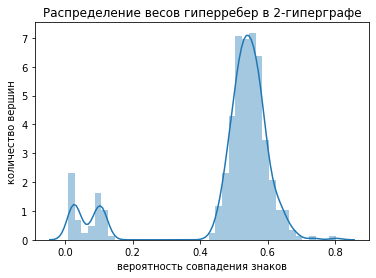

In [20]:
import seaborn as sns

sns_plot = sns.distplot(list(hipergraph_edges[2].values()))
sns_plot.set_title('Распределение весов гиперребер в 2-гиперграфе')
sns_plot.set_xlabel("вероятность совпадения знаков")
sns_plot.set_ylabel("количество вершин")
fig = sns_plot.get_figure()

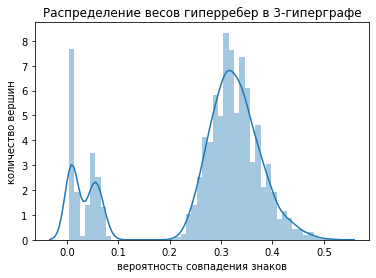

In [14]:
sns_plot = sns.distplot(list(hipergraph_edges[3].values()))
sns_plot.set_title('Распределение весов гиперребер в 3-гиперграфе')
sns_plot.set_xlabel("вероятность совпадения знаков")
sns_plot.set_ylabel("количество вершин")
fig = sns_plot.get_figure()

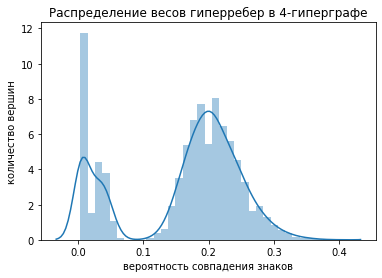

In [15]:
sns_plot = sns.distplot(list(hipergraph_edges[4].values()))
sns_plot.set_title('Распределение весов гиперребер в 4-гиперграфе')
sns_plot.set_xlabel("вероятность совпадения знаков")
sns_plot.set_ylabel("количество вершин")
fig = sns_plot.get_figure()

Text(0, 0.5, 'количество вершин')

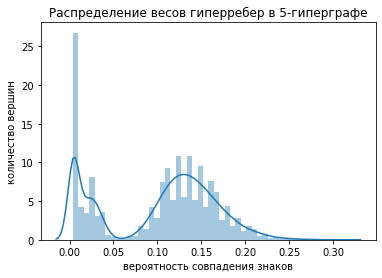

In [16]:
sns_plot = sns.distplot(list(hipergraph_edges[5].values()))
sns_plot.set_title('Распределение весов гиперребер в 5-гиперграфе')
sns_plot.set_xlabel("вероятность совпадения знаков")
sns_plot.set_ylabel("количество вершин")
#fig = sns_plot.get_figure()

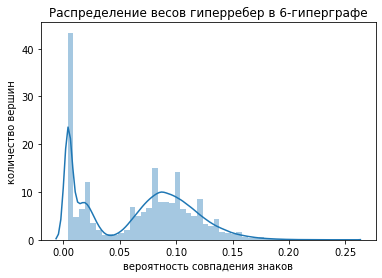

In [17]:
sns_plot = sns.distplot(list(hipergraph_edges[6].values()))
sns_plot.set_title('Распределение весов гиперребер в 6-гиперграфе')
sns_plot.set_xlabel("вероятность совпадения знаков")
sns_plot.set_ylabel("количество вершин")
fig = sns_plot.get_figure()

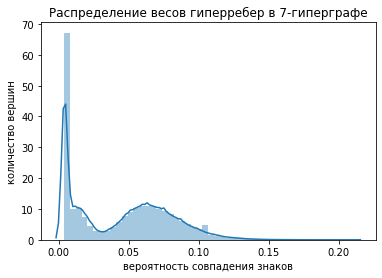

In [18]:
sns_plot = sns.distplot(list(hipergraph_edges[7].values()))
sns_plot.set_title('Распределение весов гиперребер в 7-гиперграфе')
sns_plot.set_xlabel("вероятность совпадения знаков")
sns_plot.set_ylabel("количество вершин")
fig = sns_plot.get_figure()

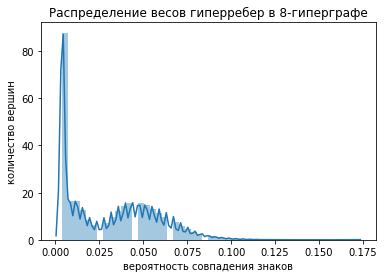

In [19]:
sns_plot = sns.distplot(list(hipergraph_edges[8].values()))
sns_plot.set_title('Распределение весов гиперребер в 8-гиперграфе')
sns_plot.set_xlabel("вероятность совпадения знаков")
sns_plot.set_ylabel("количество вершин")
fig = sns_plot.get_figure()